[Shop The LooK Dataset](https://github.com/kang205/STL-Dataset) provides two datasets for fashion and home respectively. Each dataset contains the scene-product pairs in the following format:

```
Example (fashion.json):
{
    "product": "0027e30879ce3d87f82f699f148bff7e", 
    "scene": "cdab9160072dd1800038227960ff6467", 
    "bbox": [
        0.434097, 
        0.859363, 
        0.560254, 
        1.0
    ]
}
```

Product is an image of a product in professional setting whereas a scene is the image of the same product but in casual or non-professional setting. Each dataset contains the scene-product pairs in the following format, where scene and products are encoded with a signature that can be converted to an url by using a function provided in the official github repository.

In [1]:
import os
import cv2
import shutil
import random
import json
import warnings
warnings.simplefilter('ignore')
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage import io
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
STL_DATASET_BASE_DIR = "./STL-Dataset"
files = [os.path.join(STL_DATASET_BASE_DIR, x) for x in os.listdir(STL_DATASET_BASE_DIR) if x.endswith(".json")]

In [3]:
with open(files[0], "r") as f:
    categories = json.load(f)

In [4]:
categories['0027e30879ce3d87f82f699f148bff7e']

'Apparel & Accessories|Shoes'

In [5]:
data = [json.loads(line) for line in open(files[1], 'r')]
data = pd.DataFrame(data)
data

product                             scene  \
0      0027e30879ce3d87f82f699f148bff7e  cdab9160072dd1800038227960ff6467   
1      0027e30879ce3d87f82f699f148bff7e  14f59334af4539132981b1324a731067   
2      0027e30879ce3d87f82f699f148bff7e  e7d32df9f45b691afc580808750f73ca   
3      0027e30879ce3d87f82f699f148bff7e  c0be585ed21b1a6c6dc9559ebe007ede   
4      002a6586b8381b5efd39410657630b44  67ed2a06be8a26dc63d7a04d4e1a135f   
...                                 ...                               ...   
72193  f47eacd512acfdcfaf5f402809acb333  0a8d63baa456499a3dd2c4886385cf13   
72194  f47eacd512acfdcfaf5f402809acb333  31e3620642773bfeac3e9d1a4976205c   
72195  f940d17f294fec78c913e9536735bea1  cc764ccff4d6e1abb3ea1ecc1503f8bf   
72196  fd8de790fe45ef01ebc8fe47a6e80138  a1f27a961c577230d0cea68f6e59b36a   
72197  ff3f110f702999cafb48958e37365900  f8b511621ffd30eefd5af251012e9934   

                                           bbox  
0           [0.434097, 0.859363, 0.560254, 1.0]  
1      [0.175269, 0.527773, 0.621485, 0.924899]  
2      [0.588666, 0.638503, 0.750647, 0.761368]  
3      [0.276699, 0.757741, 0.400485, 0.876138]  
4      [0.154545, 0.144809, 0.809091, 0.784153]  
...                                         ...  
72193      [0.456818, 0.343636, 0.75, 0.629091]  
72194    [0.378297, 0.6209, 0.790087, 0.982056]  
72195  [0.627266, 0.456562, 0.823383, 0.654216]  
72196   [0.235259, 0.824805, 0.39719, 0.974153]  
72197   [0.302811, 0.281136, 0.64136, 0.672962]  

[72198 rows x 3 columns]

In [6]:
def convert_to_url(signature):
    """
    Convert Image signatures/ids to urls
    """
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

def categorize(x):
    """
    Categorize products into 3 broad categories - Topwear, Bottomwear and Footwear
    """
    if x == 'Shoes':
        return 'footwear'
    elif x in ['Clothing|Pants', 'Clothing|Shorts', 'Clothing|Skirts']:
        return 'bottomwear'
    else:
        return 'topwear'

In [7]:
data['category'] = data['product'].apply(lambda x: categories[x].replace('Apparel & Accessories|', ''))
data = data[data['category'].apply(lambda x: True if ('Clothing' in x) or ('Shoes' in x) else False)]
data = data[data['category'].apply(lambda x: True if ('Sunglasses' not in x) else False)]
data['category'] = data['category'].apply(lambda x: categorize(x))
data['product'] = data['product'].apply(lambda x: convert_to_url(x))
data['scene'] = data['scene'].apply(lambda x: convert_to_url(x))
data['XMIN'] = data['bbox'].apply(lambda x: x[0])
data['YMIN'] = data['bbox'].apply(lambda x: x[1])
data['XMAX'] = data['bbox'].apply(lambda x: x[2])
data['YMAX'] = data['bbox'].apply(lambda x: x[3])
data = data.drop(["bbox"], axis=1)

print("Total Samples", data.shape[0])
data.head()

Total Samples 58364


product  \
0  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
1  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
2  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
3  http://i.pinimg.com/400x/00/27/e3/0027e30879ce...   
5  http://i.pinimg.com/400x/00/f9/27/00f9272f652f...   

                                               scene    category      XMIN  \
0  http://i.pinimg.com/400x/cd/ab/91/cdab9160072d...    footwear  0.434097   
1  http://i.pinimg.com/400x/14/f5/93/14f59334af45...    footwear  0.175269   
2  http://i.pinimg.com/400x/e7/d3/2d/e7d32df9f45b...    footwear  0.588666   
3  http://i.pinimg.com/400x/c0/be/58/c0be585ed21b...    footwear  0.276699   
5  http://i.pinimg.com/400x/b6/9e/7f/b69e7fd5c674...  bottomwear  0.319045   

       YMIN      XMAX      YMAX  
0  0.859363  0.560254  1.000000  
1  0.527773  0.621485  0.924899  
2  0.638503  0.750647  0.761368  
3  0.757741  0.400485  0.876138  
5  0.409877  0.724975  0.865827

In [8]:
sample = data[data.category=='topwear'][['product', 'scene']].values[0]
titles = ['product', 'scene']

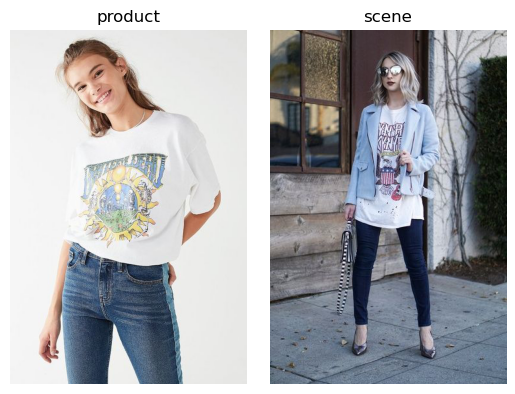

In [9]:
fig, axs = plt.subplots(1, len(sample))

for i, image_url in enumerate(sample):
    image_data = urllib.request.urlopen(image_url)
    image = plt.imread(image_data, format='jpg')
    axs[i].imshow(image)
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

In [10]:
print("Number of Unique Products:\t", data["product"].nunique())
print("Number of Unique Scenes:\t", data["scene"].nunique())

Number of Unique Products:	 31249
Number of Unique Scenes:	 25799


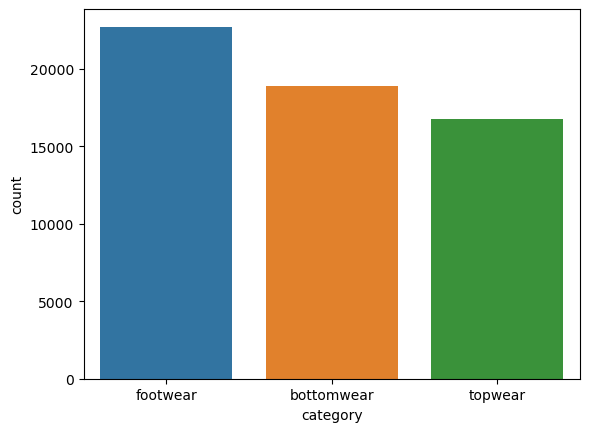

In [11]:
sns.countplot(data.category)
plt.show();

In [12]:
topwear = data[data['category'] == 'topwear'].sample(8500).reset_index(drop=True)
bottomwear = data[data['category'] == 'bottomwear'].sample(8500).reset_index(drop=True)
footwear = data[data['category'] == 'footwear'].sample(8500).reset_index(drop=True)

In [13]:
def download_images(dataframe, target_folder):  
    """
    Download images by using the URL and save it locally.
    """
    embeddings_dir = "embeddings_train_data"
    data = list()
    if not os.path.exists(embeddings_dir):
        os.mkdir(embeddings_dir)
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        try:
            product_url, product_name = row["product"], row["product"].split("/")[-1]
            scene_url, scene_name = row["scene"], row["scene"].split("/")[-1]
            target_dir = os.path.join(embeddings_dir, target_folder)
            if not os.path.exists(target_dir):
                os.mkdir(target_dir)
                os.mkdir(os.path.join(target_dir, "anchor"))
                os.mkdir(os.path.join(target_dir, "positive"))
            if not os.path.isfile(os.path.join(target_dir, "anchor", product_name)):
                product = Image.fromarray(io.imread(product_url))
                product.save(os.path.join(target_dir, "anchor", product_name))
            if not os.path.isfile(os.path.join(target_dir, "positive", scene_name)):
                scene = io.imread(scene_url)
                XMIN, YMIN, XMAX, YMAX = int(scene.shape[1] * row['XMIN']), int(scene.shape[0] * row['YMIN']), int(scene.shape[1] * row['XMAX']), int(scene.shape[0] * row['YMAX']) 
                scene = Image.fromarray(scene[YMIN:YMAX, XMIN:XMAX])
                scene.save(os.path.join(target_dir, "positive", scene_name))
            data.append((os.path.join(target_dir, "anchor", product_name), os.path.join(target_dir, "positive", scene_name)))
        except Exception as e:
            print(f"Error: {e}")
            continue
    return data

def create_negative(List, positive):
    """
    Select a random image from the same category that will act as negative samples.
    """
    negative = random.choice(List)
    if negative != positive:
        return negative
    else:
        create_negative(List, positive)
        
def plot_samples(dataframe, size=4, random_state=4):
    """
    Plot Anchor, Positive and Negative images in a row for a given batch of images.
    """
    for _, row in dataframe.sample(n=size, random_state=random_state).iterrows():
        anchor, positive, negative = row["anchor"], row["positive"], row["negative"] 
        anchor, positive, negative = io.imread(anchor), io.imread(positive), io.imread(negative)
        plt.figure(figsize=(16,9))
        plt.subplot(131)
        plt.imshow(anchor)
        plt.axis("off"); plt.title("Anchor")
        plt.subplot(132)
        plt.imshow(positive)
        plt.axis("off"); plt.title("Positive")
        plt.subplot(133)
        plt.imshow(negative)
        plt.axis("off"); plt.title("Negative")
        plt.show() 

## Topwear

In [14]:
top_pairs = download_images(topwear, "topwear")

In [16]:
top_pairs_csv = pd.DataFrame(top_pairs, columns=["anchor", "positive"])
top_pairs_csv["negative"] = top_pairs_csv["positive"].apply(lambda x: create_negative(top_pairs_csv.positive.to_list(), x)) 
print("Total Pairs: ", top_pairs_csv.shape[0])
top_pairs_csv.to_csv("top_pairs.csv", index=False)

Total Pairs:  8498


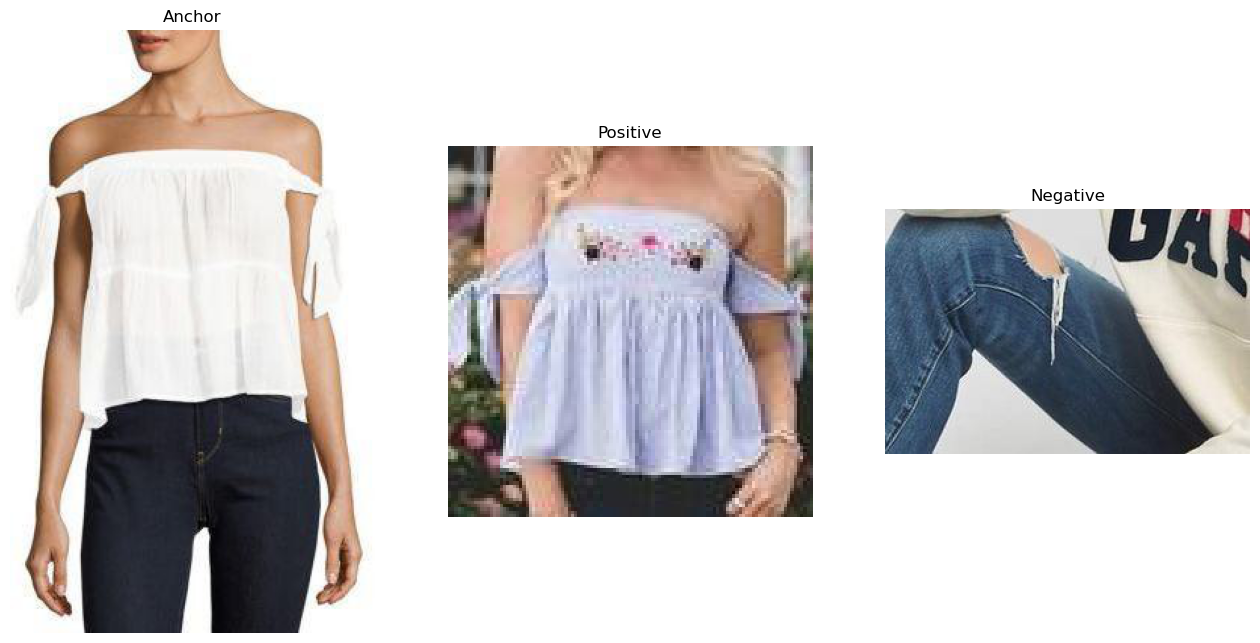

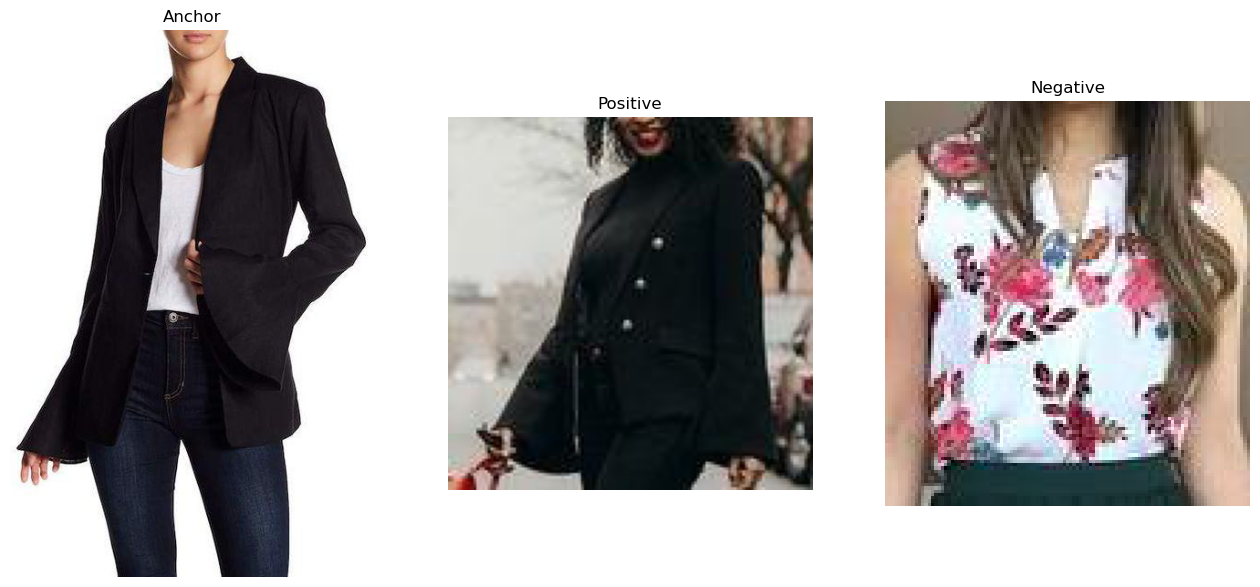

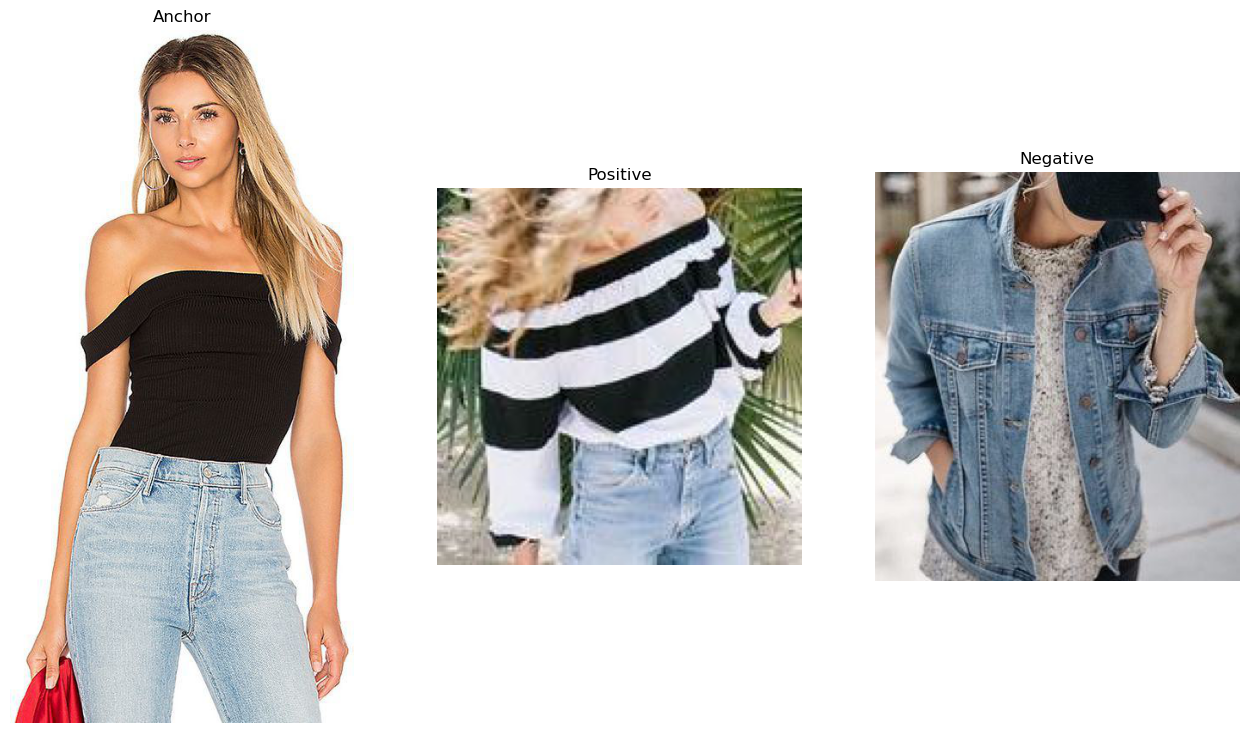

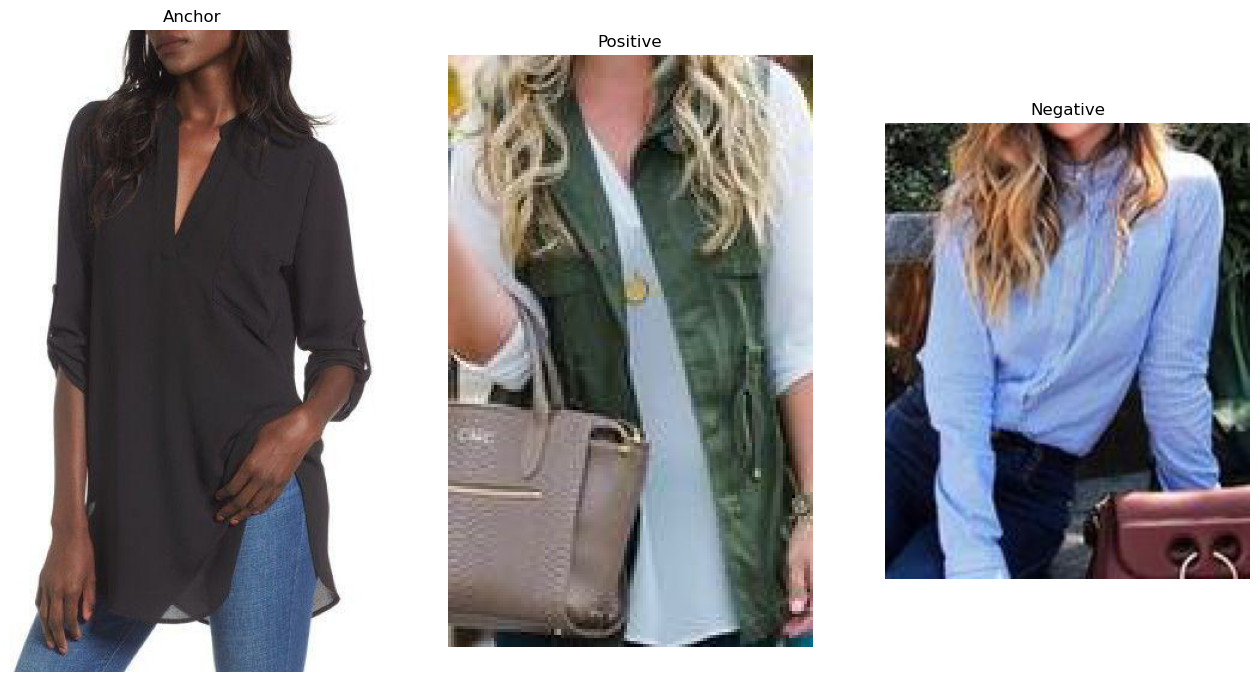

In [17]:
plot_samples(top_pairs_csv)

## Bottomwear

In [18]:
bottom_pairs = download_images(bottomwear, "bottomwear")

In [20]:
bottom_pairs_csv = pd.DataFrame(bottom_pairs, columns=["anchor", "positive"])
bottom_pairs_csv["negative"] = bottom_pairs_csv["positive"].apply(lambda x: create_negative(bottom_pairs_csv.positive.to_list(), x))
print("Total Pairs: ", bottom_pairs_csv.shape[0])
bottom_pairs_csv.to_csv("bottom_pairs.csv", index=False)

Total Pairs:  8497


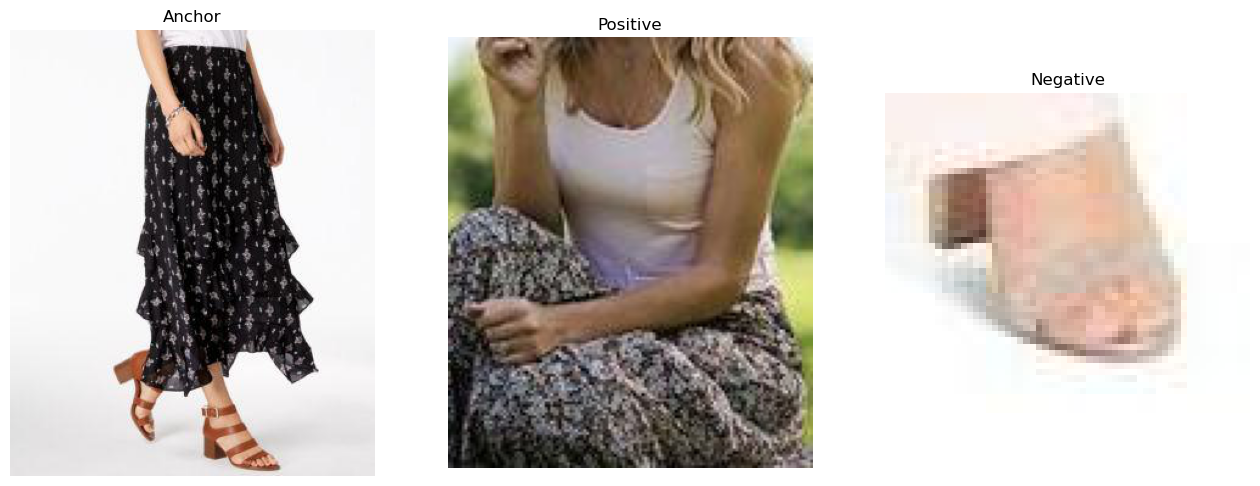

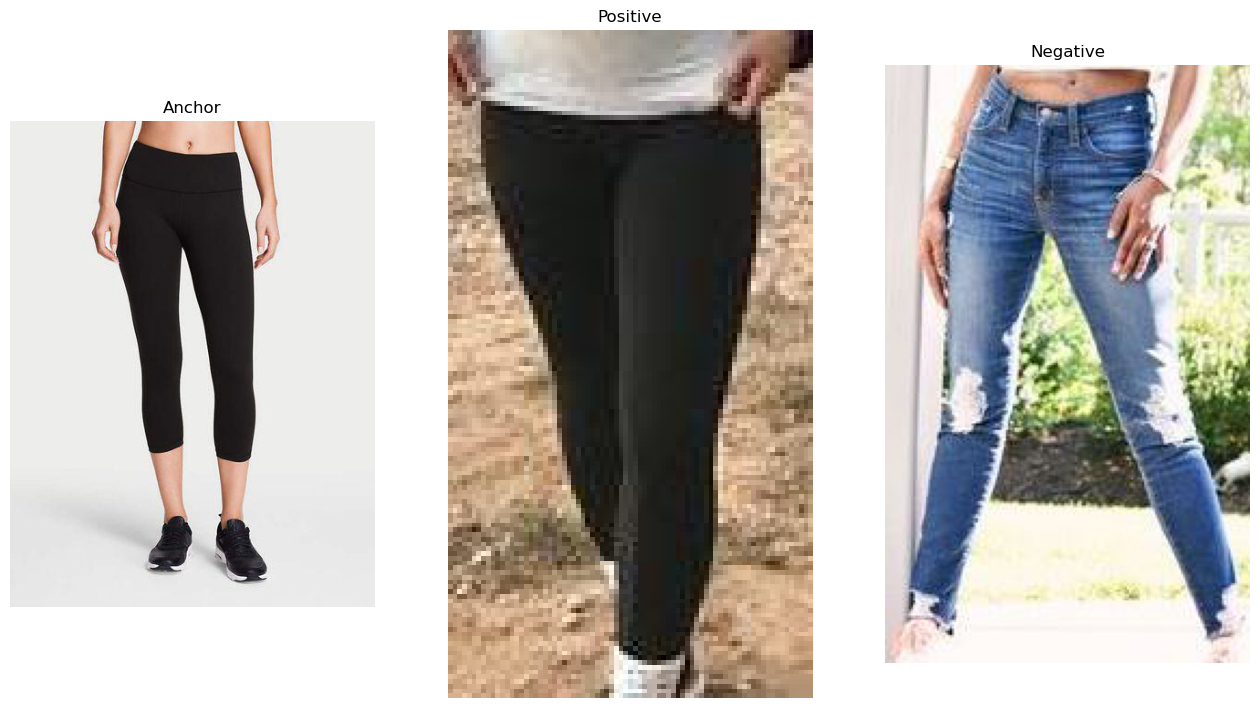

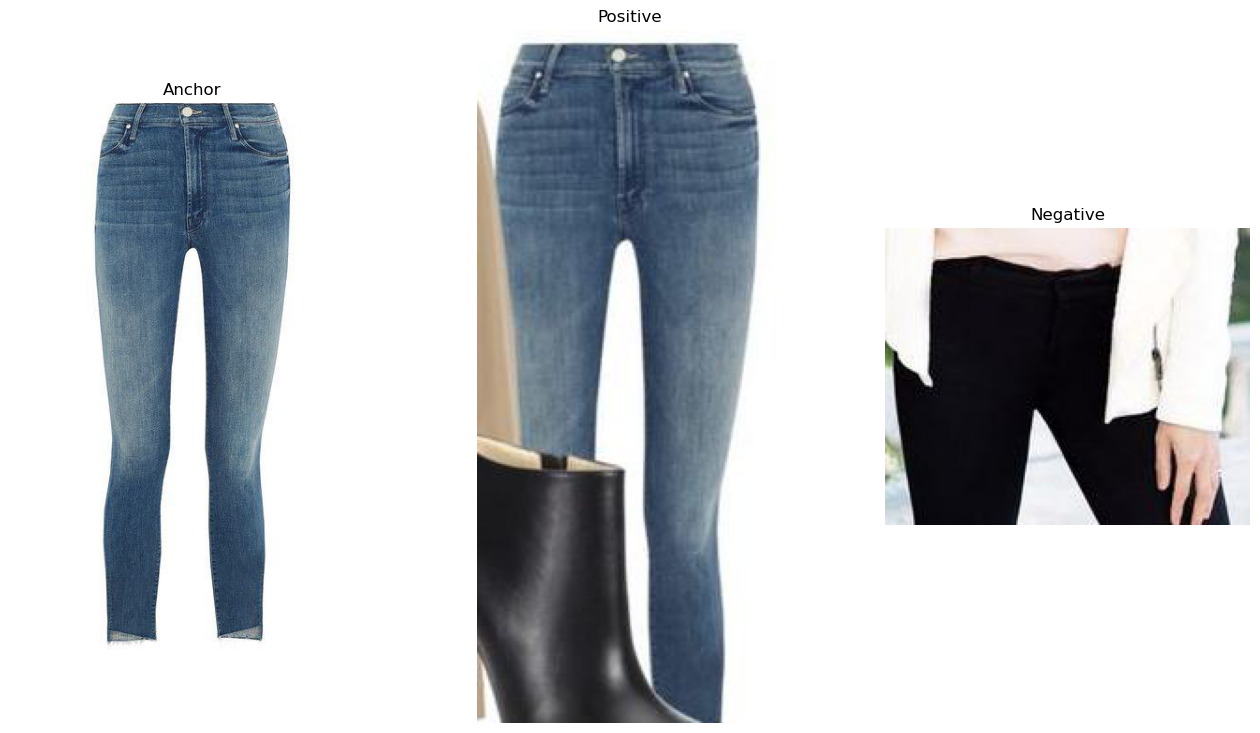

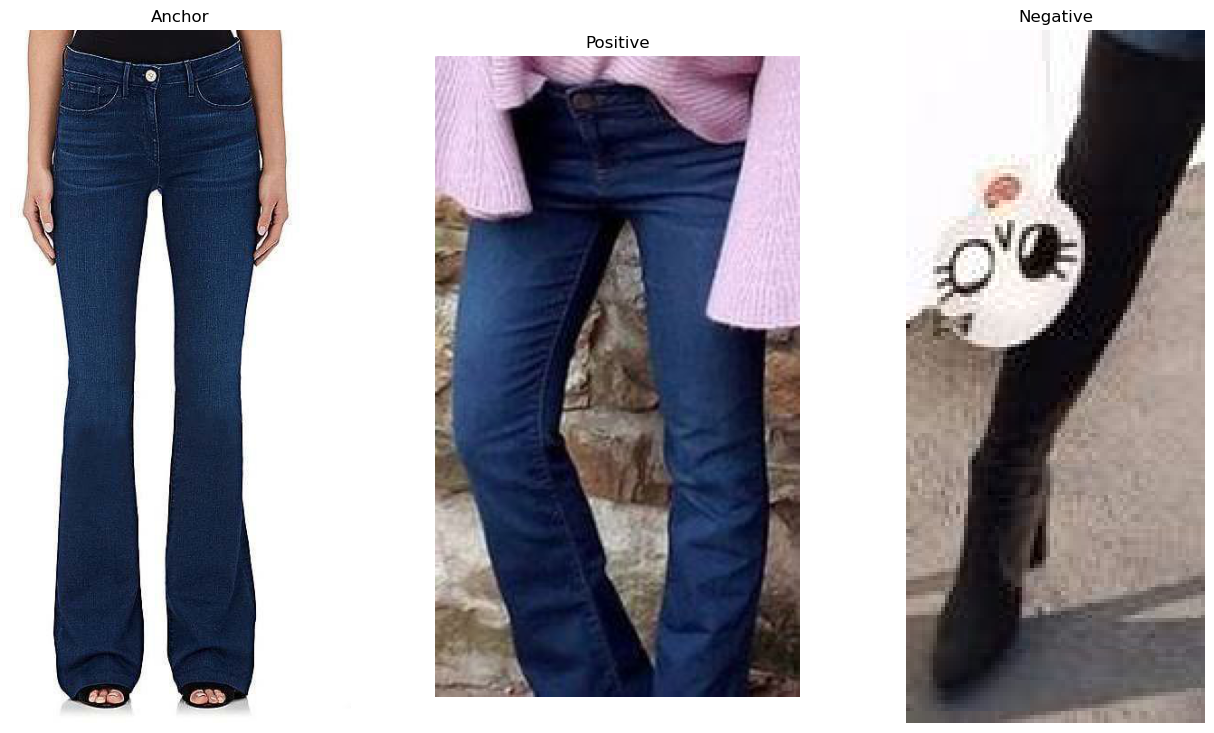

In [23]:
plot_samples(bottom_pairs_csv, random_state=10)

## Footwear

In [25]:
foot_pairs = download_images(footwear, "footwear")

In [28]:
foot_pairs_csv = pd.DataFrame(foot_pairs, columns=["anchor", "positive"])
foot_pairs_csv["negative"] = foot_pairs_csv["positive"].apply(lambda x: create_negative(foot_pairs_csv.positive.to_list(), x))
print("Total Pairs: ", foot_pairs_csv.shape[0])
foot_pairs_csv.to_csv("foot_pairs.csv", index=False)

Total Pairs:  8500


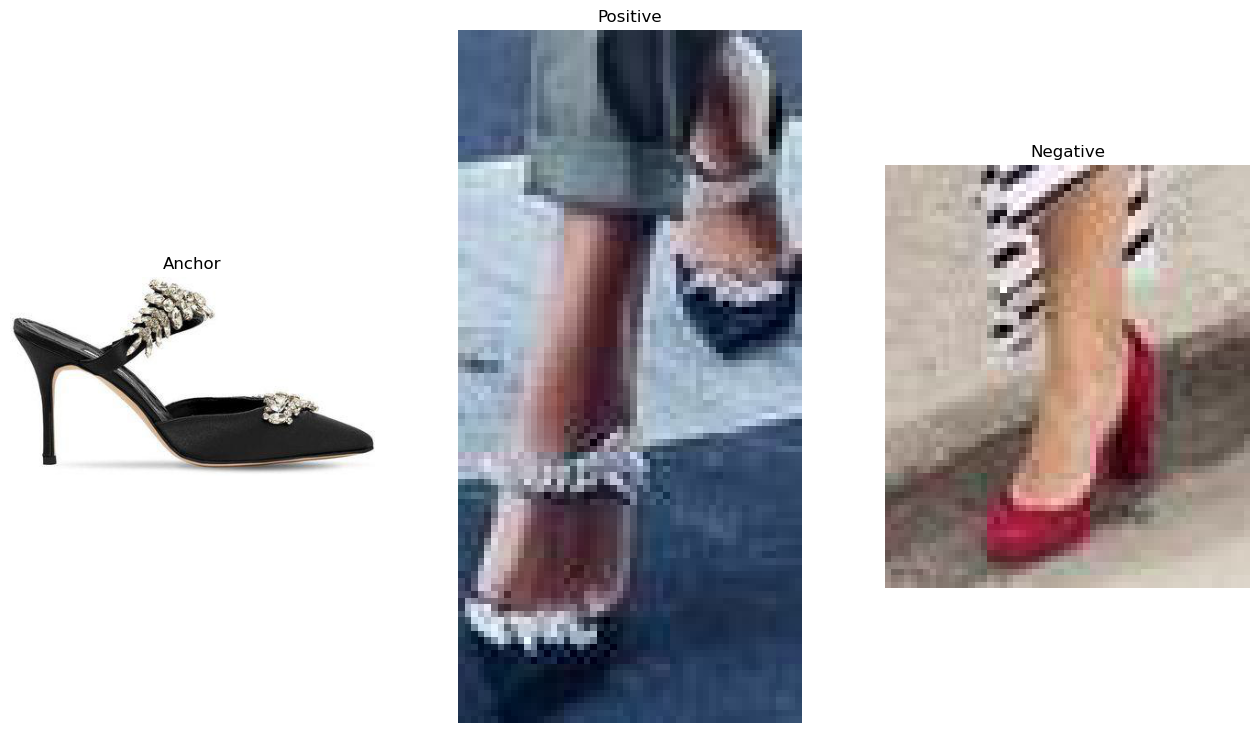

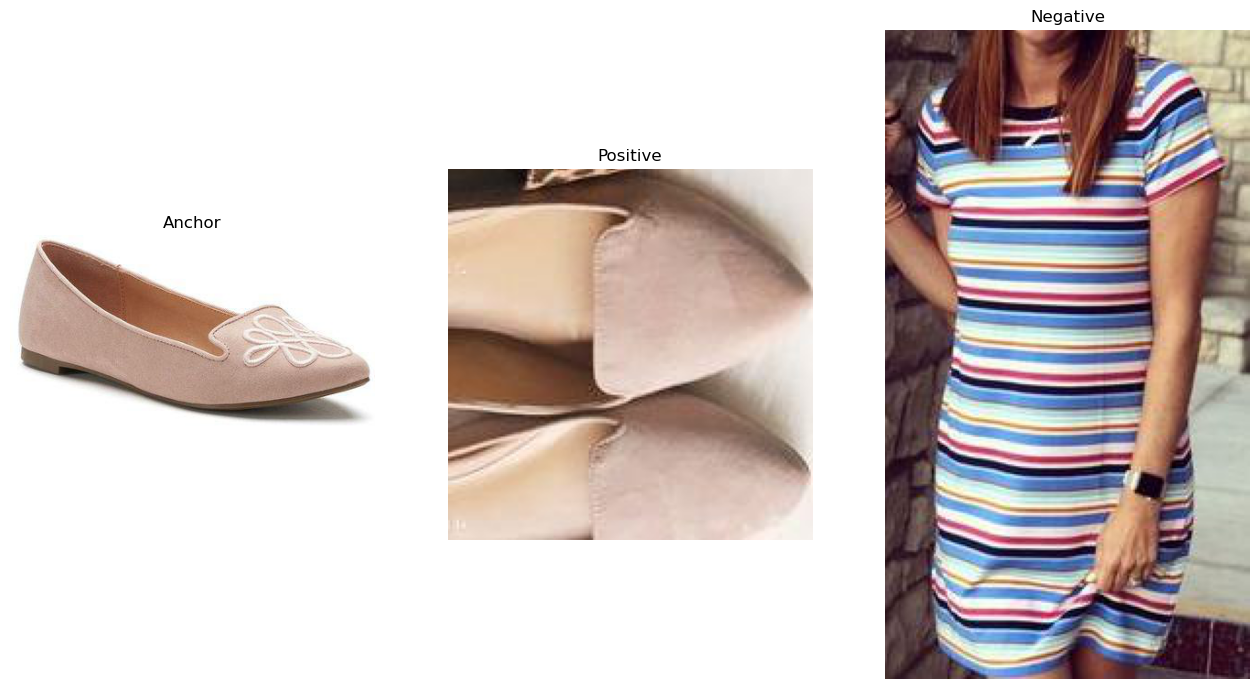

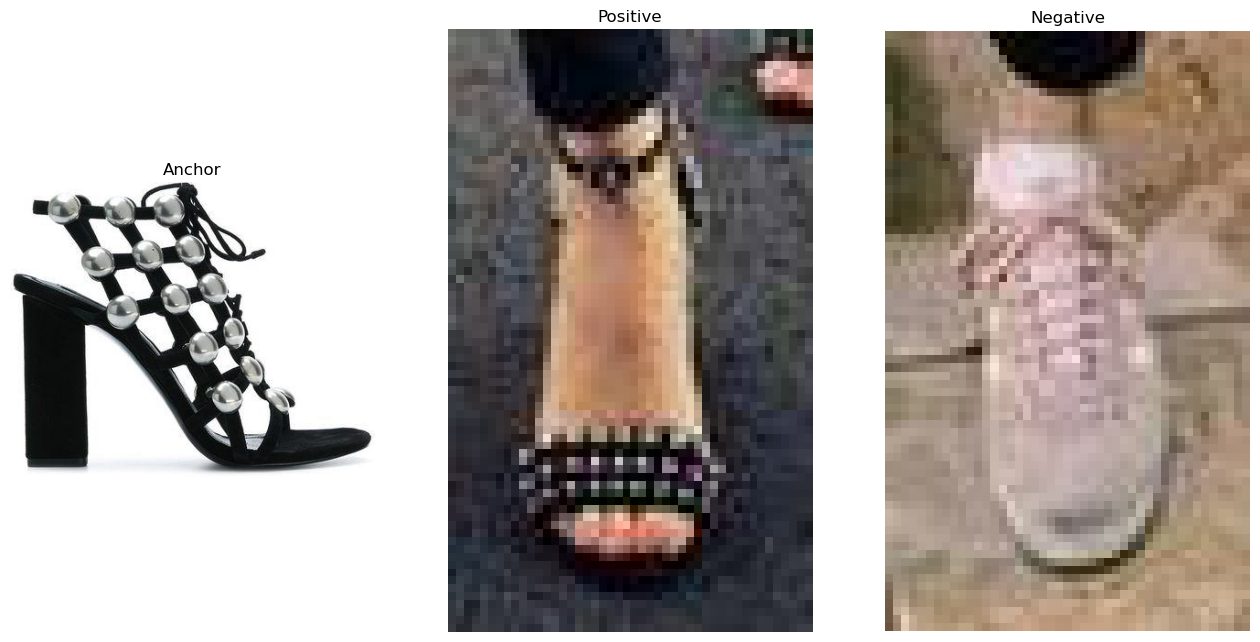

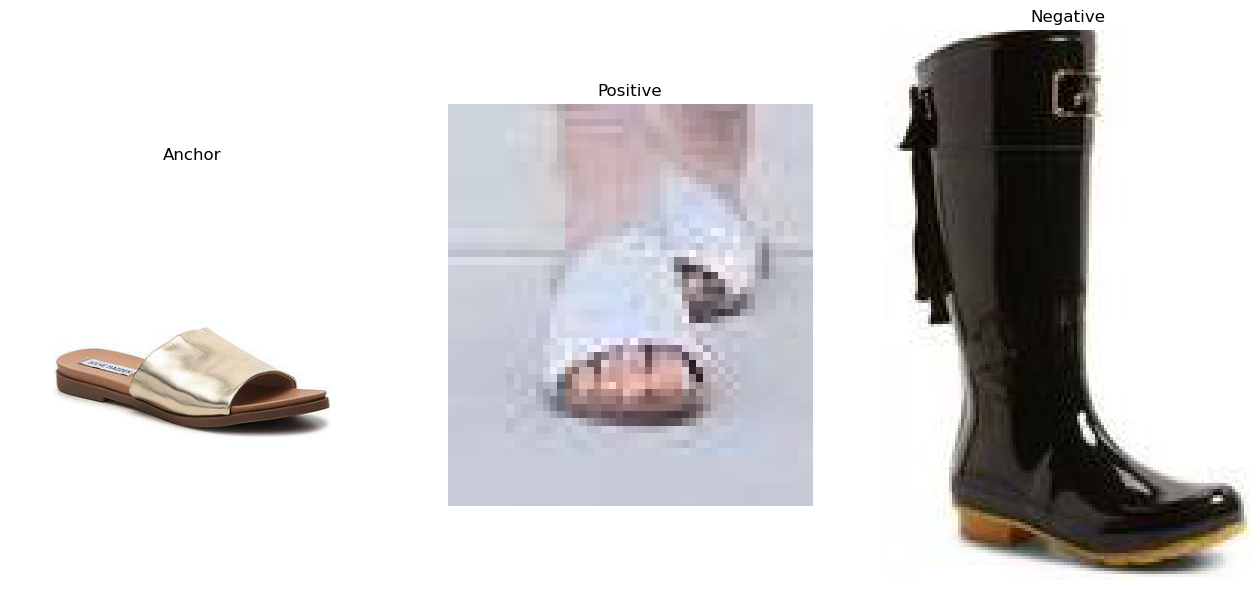

In [40]:
plot_samples(foot_pairs_csv, random_state=50)